![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

# Arquivos
filename_features = "features.txt"
filename_labels = "activity_labels.txt"

filename_subtrain = "subject_train.txt"
filename_xtrain = "X_train.txt"
filename_ytrain = "y_train.txt"

filename_subtest = "subject_test.txt"
filename_xtest = "X_test.txt"
filename_ytest = "y_test.txt"

# Leitura dos dados
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")['nome_var']
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])


C:\Users\Usuario\AppData\Local\Temp\ipykernel_24004\1625842136.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24004\1625842136.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24004\1625842136.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

PCA sem padronização:


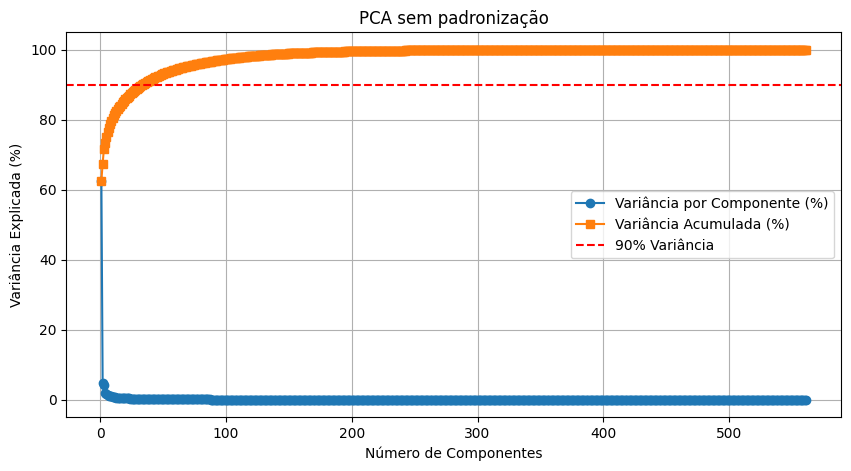

Componentes para 90% variância: 34
PCA com padronização:


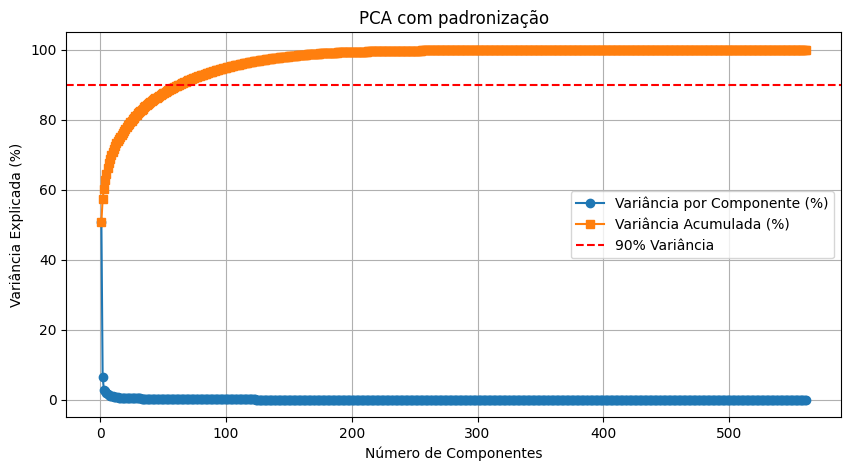

Componentes para 90% variância: 63


In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def padroniza(s):
    if s.std() > 0:
        return (s - s.mean()) / s.std()
    return s

X_train_pad = X_train.apply(padroniza, axis=0)

pca_raw = PCA()
pca_raw.fit(X_train)

pca_scaled = PCA()
pca_scaled.fit(X_train_pad)

def plot_variance(pca, title):
    var_exp = pca.explained_variance_ratio_
    cum_var_exp = var_exp.cumsum()
    
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(var_exp)+1), var_exp * 100, marker='o', label='Variância por Componente (%)')
    plt.plot(range(1, len(var_exp)+1), cum_var_exp * 100, marker='s', label='Variância Acumulada (%)')
    plt.axhline(90, color='r', linestyle='--', label='90% Variância')
    plt.title(title)
    plt.xlabel('Número de Componentes')
    plt.ylabel('Variância Explicada (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    n_90 = (cum_var_exp >= 0.9).argmax() + 1
    print(f'Componentes para 90% variância: {n_90}')

print("PCA sem padronização:")
plot_variance(pca_raw, "PCA sem padronização")

print("PCA com padronização:")
plot_variance(pca_scaled, "PCA com padronização")

Sem padronização, apenas 34 componentes explicam 90% da variância porque variáveis com escala maior dominam a análise. Com padronização, é necessário mais componentes (63) para atingir 90%, pois todas as variáveis contribuem de forma equilibrada. Portanto, padronizar evita que variáveis com maior escala prejudiquem a análise, mesmo que precise de mais componentes para explicar a variância total.

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import time

def padroniza(s):
    if s.std() > 0:
        return (s - s.mean()) / s.std()
    return s

X_train_pad = X_train.apply(padroniza, axis=0)
X_test_pad = X_test.apply(padroniza, axis=0)

pca_raw = PCA(n_components=10)
X_train_pca_raw = pca_raw.fit_transform(X_train)
X_test_pca_raw = pca_raw.transform(X_test)

pca_scaled = PCA(n_components=10)
X_train_pca_scaled = pca_scaled.fit_transform(X_train_pad)
X_test_pca_scaled = pca_scaled.transform(X_test_pad)

def arvore_decisao(X_train, y_train, X_test, y_test):
    clf = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
    start = time.time()
    clf.fit(X_train, y_train)
    tempo = time.time() - start

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    return acc_train, acc_test, tempo

acc_train_raw, acc_test_raw, tempo_raw = arvore_decisao(X_train_pca_raw, y_train, X_test_pca_raw, y_test)

acc_train_scaled, acc_test_scaled, tempo_scaled = arvore_decisao(X_train_pca_scaled, y_train, X_test_pca_scaled, y_test)

print("Árvore com PCA (10 componentes) SEM padronização:")
print(f"Acurácia treino: {acc_train_raw:.4f}")
print(f"Acurácia teste: {acc_test_raw:.4f}")
print(f"Tempo de execução: {tempo_raw:.2f} segundos\n")

print("Árvore com PCA (10 componentes) COM padronização:")
print(f"Acurácia treino: {acc_train_scaled:.4f}")
print(f"Acurácia teste: {acc_test_scaled:.4f}")
print(f"Tempo de execução: {tempo_scaled:.2f} segundos")

Árvore com PCA (10 componentes) SEM padronização:
Acurácia treino: 0.8927
Acurácia teste: 0.8242
Tempo de execução: 0.12 segundos

Árvore com PCA (10 componentes) COM padronização:
Acurácia treino: 0.8587
Acurácia teste: 0.7737
Tempo de execução: 0.10 segundos


Ao usar PCA com 10 componentes, a árvore de decisão teve melhor desempenho sem padronização (acurácia teste de 82,4%) do que com padronização (77,4%). O tempo de execução foi parecido e baixo em ambos os casos. Isso sugere que, para essa base, a padronização das variáveis pode reduzir um pouco a performance do modelo, mas melhora a generalização para variáveis com diferentes escalas em geral.